In [141]:
from scipy.stats import ks_2samp, iqr
from scipy.stats import ttest_ind
from IPython.display import Markdown, display
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import time
from datetime import datetime
%matplotlib inline
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [142]:
# set paths
data_dir = "./"
# files extracted by prepare_evaluation_input.py script

sim_file = "./simulator_output/ orders_times_SEV_2019-12-01_2019-12-01.csv"
#sim_file = "./simulator_output/orders_times.csv"

dwh_file = "reality_data/SEV_2019-12-01_2019-12-01.csv"


# read data
sim_dt = pd.read_csv(sim_file)
real_dt = pd.read_csv(os.path.join(data_dir, dwh_file))



In [143]:
# dirty workaround to get rid off multiindexing -> to fix later

sim_dt1 = sim_dt.filter(regex=("times_diff*" ))
sim_dt1.loc[:,"order_id"] = sim_dt.loc[:,"Unnamed: 1"]
sim_dt1.loc[:,"courier_starts_order"] =sim_dt.loc[:,"timestamp_hms.2"]
sim_dt1.loc[:,"activation_time"] =sim_dt.loc[:,"timestamp_hms.9"]
sim_dt1 = sim_dt1[sim_dt1.columns[::-1]]

In [144]:

sim_dt = sim_dt1
columns = sim_dt1.iloc[0]
#print(columns)
columns[0] = "activation_time"
columns[2] = "order_id"
sim_dt.columns =columns
sim_dt = sim_dt.drop([0,1])

In [145]:
# simulator output postprocessing
sim_dt = sim_dt.rename(columns={"waiting_time_pickup": "waiting_pickup_time"})
# add missing columns

# TODO: remove - should be already in the data (or add to the script)

sim_dt["prioritized_pickup"] = False
sim_dt["start_to_pickup_distance"] = 200

In [146]:
# TODO: CHANGE IN DATA ETL data matrix manager
real_dt.loc[:,'first_stacking_to_courier_start'] = real_dt.loc[:,'first_stacking_to_last_stacking'] + real_dt.loc[:,'last_stacking_to_courier_start']
real_dt = real_dt.rename(columns={"vertical":"order_category"})

#simulation data
sim_dt.loc[:,'first_stacking_to_last_stacking'] = sim_dt.loc[:,'first_stacking_to_last_stacking'].astype(float)
sim_dt.loc[:,'last_stacking_to_courier_start'] = sim_dt.loc[:,'last_stacking_to_courier_start'].astype(float)
sim_dt.loc[:,'first_stacking_to_courier_start'] = sim_dt.loc[:,'first_stacking_to_last_stacking'] + sim_dt.loc[:,'last_stacking_to_courier_start']

#sim_dt.loc[:, "activation_time"] = sim_dt.loc[:, "courier_starts_order"]

In [147]:
# metrics we want to track
metrics = ['customer_delivery_time','courier_delivery_time', 'activation_to_first_stacking',
       'first_stacking_to_courier_start', 'start_to_pickup_time','pickup_to_delivery_time',
        'waiting_pickup_time', 'waiting_delivery_time','pickup_to_delivery_distance',
       'start_to_pickup_distance', 'activation_to_partner_dispatch', 'partner_dispatch_to_enter_pickup']
time_metrics = ['customer_delivery_time','courier_delivery_time', 'activation_to_first_stacking',
       'first_stacking_to_courier_start', 'start_to_pickup_time','pickup_to_delivery_time',
        'waiting_pickup_time', 'waiting_delivery_time']
dist_metrics = ['pickup_to_delivery_distance','start_to_pickup_distance']

In [148]:
## FUNCTIONS
def printmd(string):
    display(Markdown(string))

def detect_outliers(data, q1,q2, threshold):
    # calculate interquartile range
    q25, q75 = np.nanpercentile(data, q1), np.nanpercentile(data, q2)
    iqr = q75 - q25
  #  print('Percentiles: 25th=%.3f, 75th=%.3f, IQR=%.3f' % (q25, q75, iqr))
    # calculate the outlier cutoff
    cut_off = iqr*threshold
    lower, upper = q25 - cut_off, q75 + cut_off
    # identify outliers
    outliers = [x for x in data if x < lower or x > upper]
    # remove outliers
    no_outliers = [x for x in data if x >= lower and x <= upper]
    return no_outliers, outliers

def get_statistics(real_no_outl, real_outl, idx, q1,q2):
    # real_no_outl - values (the list) with outliers filtered out
    # real_outl - outliers
    # idx - real or sim
    # q1,q2 percentiles to compute interquantile range
    #print("otutl, len(real_no_outl))
    #print("sim", len(real_outl))
    N = len(real_no_outl) + len(real_outl)
    q25, q75 = np.nanpercentile(real_no_outl, q1), np.nanpercentile(real_no_outl, q2)
    q25, q75 = round(q25,2), round(q75,2)
    if N != 0:
        outl_no = round(100*len(real_outl)/N,2)
    else:
        outl_no = 0
    row_real = pd.DataFrame({"mean": round(np.mean(real_no_outl),2), "std": round(np.std(real_no_outl),2),\
                         "outliers no": len(real_outl), "outliers %": outl_no,
                        "q"+str(q1):q25, "q"+str(q2):q75},
                         index=[idx]
                       )
    return row_real

def print_avg_diff(real_dt_col, sim_dt_col):
    m1 = np.mean(real_dt_col)
    m2 = np.mean(sim_dt_col)
    m_delta = round( m1-m2,2)
    printmd(rf"""$\Delta \mu = {m_delta}$ min [real - simulation]""")
    
def print_avg_diff_dist(real_dt_col, sim_dt_col):
    m1 = np.mean(real_dt_col)
    m2 = np.mean(sim_dt_col)
    m_delta = round( m1-m2,2)
    printmd(rf"""$\Delta \mu = {m_delta}$ m [real - simulation]""")

def convert_formats(dt):
    time_cols = ['activation_time', 'activation_time_local',
       'pickup', 'delivery', 'is_food', 'partner_order', 'waiting_pickup_time',
       'first_stacking', 'courier_start', 'entering_pickup',
       'entering_delivery', 'partner_dispatch', 'partner_accepted']
    dist_cols = ['pickup_latitude', 'pickup_longitude', 'delivery_latitude',
       'delivery_longitude', 'courier_start_latitude',
       'courier_start_longitude', 'pickup_to_delivery_distance', 'start_to_pickup_distance']
    int_cols = ['courier_delivery_time', 'order_id'
       'customer_delivery_time', 'activation_to_first_stacking',
       'first_stacking_to_courier_start', 'start_to_pickup_time',
       'pickup_to_delivery_time', 'waiting_delivery_time']
    #dt[time_cols] = parse_time(dt, time_cols)
    dt[dist_cols] = dt[dist_cols].astype(float)
    dt[int_cols] = dt[int_cols].astype(int)

    return dt

In [149]:
# change format for simulator output
sim_dt["order_id"] = sim_dt["order_id"].astype(float)
cols = ['partner_dispatch_to_enter_pickup',
       'activation_to_partner_dispatch', 'waiting_delivery_time',
       'pickup_to_delivery_time', 'food_getting_cold', 'waiting_pickup_time',
       'start_to_pickup_time', 'last_stacking_to_courier_start',
       'first_stacking_to_last_stacking', 'activation_to_first_stacking',
       'customer_delivery_time', 'courier_delivery_time',
       'first_stacking_to_courier_start']
sim_dt[cols] = sim_dt[cols].astype(float)

In [150]:
## DATA PREPROCESSING
sim_dt[time_metrics] = sim_dt[time_metrics].astype(float)

# change for mins
sim_dt[time_metrics] = sim_dt[time_metrics].apply(lambda x: x/60, axis=1)
real_dt[time_metrics] = real_dt[time_metrics].apply(lambda x: x/60, axis=1)

# drop na in activation time
# TODO check na in other columns
sim_dt = sim_dt.dropna(subset = ["activation_time"])
real_dt = real_dt.dropna(subset = ["activation_time"])

#sim_dt_all = sim_dt.copy()
#real_dt_all = real_dt.copy()

#covert time to float
sim_dt[time_metrics] = sim_dt[time_metrics].astype(float)

# convert to datetime
# truncate miliseconds
real_dt.loc[:, "activation_time"] = real_dt.loc[:, "activation_time"].apply(lambda x: x[:-4])


real_dt.loc[:, "activation_time"] = real_dt.loc[:, "activation_time"].apply(lambda x: datetime.strptime(x,'%Y-%m-%d %H:%M:%S'))
real_dt.loc[:, "activation_time_date"] = real_dt.loc[:, "activation_time"].apply(lambda x: datetime.strftime(x,'%Y-%m-%d'))
real_dt.loc[:, "activation_time_hour"] = real_dt.loc[:, "activation_time"].apply(lambda x: x.hour)

sim_dt.loc[:, "activation_time"] = sim_dt.loc[:, "activation_time"].apply(lambda x: datetime.strptime(x,'%H:%M:%S'))
sim_dt.loc[:, "activation_time_date"] = sim_dt.loc[:, "activation_time"].apply(lambda x: datetime.strftime(x,'%Y-%m-%d'))
sim_dt.loc[:, "activation_time_hour"] = sim_dt.loc[:, "activation_time"].apply(lambda x: x.hour)


In [151]:
time = 'customer_delivery_time'

time_components = ['activation_to_first_stacking',
       'first_stacking_to_courier_start', 
     'start_to_pickup_time',
      'waiting_pickup_time',
       'pickup_to_delivery_time', 
     'waiting_delivery_time']



In [152]:

def get_overall_distr_by_hour(col):
    # compute the ttest to check the pvalue for avgs
    pvals_df = pd.DataFrame(columns=['hour','pvalue'])

    # TODO: check which statistical test to use!!!

    for hour in range(24):
        pvals_df_hour = dict({})
        sim_dt_per_hour = sim_dt.loc[sim_dt["activation_time_hour"] == hour]
        real_dt_per_hour = real_dt.loc[real_dt["activation_time_hour"] == hour]

        # save plots distribution
        if (len(sim_dt_per_hour) > 0 and len(real_dt_per_hour) > 0):
            ks, pv = ks_2samp(sim_dt_per_hour[col], real_dt_per_hour[col])
            pvals_df_hour[hour] = pv
        pvals_df = pvals_df.append(pd.DataFrame(list(pvals_df_hour.items()), columns=['hour', 'pvalue']), ignore_index=True)

    # compute weights - the percentage of data in each hour
    nsim = len(sim_dt)
    sim_weights = sim_dt.groupby(["activation_time_hour"], as_index= False)[col].count().\
        rename(columns={col:'sim_nrows'})
    sim_weights['sim_nrows'] = sim_weights['sim_nrows'].apply(lambda x: x/nsim)

    nreal = len(real_dt)
    real_weights = real_dt.groupby(["activation_time_hour"], as_index= False)[col].count().\
        rename(columns={col:'real_nrows'})
    real_weights['real_nrows'] = real_weights['real_nrows'].apply(lambda x: x/nreal)

    # difference

    # compute the average per hour
    real_avg_dt_per_hour = real_dt.groupby(["activation_time_hour"], as_index= False)[col].mean().\
        rename(columns={col:'real_avg_dt'})
    sim_avg_dt_per_hour = sim_dt.groupby(["activation_time_hour"], as_index= False)[col].mean().\
        rename(columns={col:'sim_avg_dt'})

    # merge simulation and real data
    diff_dt = pd.merge(real_avg_dt_per_hour, sim_avg_dt_per_hour, how='outer', on='activation_time_hour')

    # merge weights (the percentage of data in each hour)
    diff_dt = pd.merge(diff_dt, sim_weights, on="activation_time_hour", how='left')
    diff_dt = pd.merge(diff_dt, real_weights, on="activation_time_hour", how='left')

    # compute the difference
    diff_dt = diff_dt.dropna()
    diff_dt["diff"] = diff_dt['sim_avg_dt']*diff_dt['sim_nrows'] - diff_dt['real_avg_dt']*diff_dt['real_nrows']
    return diff_dt

# Simulator accuracy

The goal of below analysis is to measure the accuracy between the simulator output and real data extracted from dwh. We define the following metrics that we track: 'customer_delivery_time','courier_delivery_time', 'activation_to_first_stacking',
       'first_stacking_to_courier_start', 'start_to_pickup_time','pickup_to_delivery_time',
        'waiting_pickup_time', 'waiting_delivery_time',
        'pickup_to_delivery_distance',
       'start_to_pickup_distance'.
By comparing the distributions on different level of aggregations we are trying to identify where are the gaps between real data and the simulator.


The distributions are compared based on Kolmogonorov-Smirnov (KS) statistical test. It compares cdf obetween two samples of data.
The p-value < 0.05 indicates we cannot assume that the data are from the same distribution. 
Outliers are removed based on percentiles of data. 

The structure is following:
1. Consistency checks
2. Outlier values in CDT and DT, that may bias all the metrics
3. Data aggregated by different time components on daily level
4. In debt analysis the two key metrics: 'customer_delivery_time' and 'courier_delivery_time'.
5. For the rest of metrics there generated separate reports that consider aggregation by hours. 

# Consistency checks

The goal of this analysis is to make some basic consistency checks in order to guarantee that the orders we are simulating are the same we are using to compare accuracy. The checks we will do are the following:

1. Number of orders real vs simulation. 
2. Dates ranges.
3. Duplicates
4. Check that the orders are exactly the same (same order_id's).
5. Missing values. 

For the accuracy check, we will only keep the orders that are found both in reality and in simulation. However, they should be the same. 

In [153]:
print("Number of orders from Matrix: %d, (%d unique)" %(len(sim_dt), len(sim_dt['order_id'].unique())))
print("Number of orders from Reality: %d, (%d unique)" %(len(real_dt), len(real_dt['order_id'].unique())))
print("Range of dates-hours in Matrix: Min = ", sim_dt.activation_time.min(), 'Max = ', sim_dt.activation_time.max())
print("Range of dates-hours in Reality: Min = ", real_dt.activation_time_local.min(), 'Max = ', real_dt.activation_time_local.max())

orders_intersection = pd.merge(sim_dt[['order_id']], real_dt[['order_id']], how='inner')
print("Number of common orders in matrix and reality:", len(orders_intersection))

#We keep only orders that are found on both matrix and reality.
sim_dt = pd.merge(sim_dt, orders_intersection, on = 'order_id', how = 'inner')
real_dt = pd.merge(real_dt, orders_intersection, on = 'order_id', how = 'inner')



Number of orders from Matrix: 122, (122 unique)
Number of orders from Reality: 2099, (2099 unique)
Range of dates-hours in Matrix: Min =  1900-01-01 00:00:30 Max =  1900-01-01 12:58:37
Range of dates-hours in Reality: Min =  2019-12-01 00:00:30.000 Max =  2019-12-01 23:55:15.000
Number of common orders in matrix and reality: 107


In [154]:
sim_dt.columns

Index(['activation_time', 'courier_starts_order', 'order_id', 'partner_dispatch_to_enter_pickup', 'activation_to_partner_dispatch', 'waiting_delivery_time', 'pickup_to_delivery_time', 'food_getting_cold', 'waiting_pickup_time', 'start_to_pickup_time', 'last_stacking_to_courier_start', 'first_stacking_to_last_stacking', 'activation_to_first_stacking', 'customer_delivery_time', 'courier_delivery_time', 'prioritized_pickup', 'start_to_pickup_distance', 'first_stacking_to_courier_start', 'activation_time_date', 'activation_time_hour'], dtype='object')

# Outliers analysis

First we will use boxplots to assess the amount of potential outliers that we may find in each of the metrics for the simulated values and the real values and we will explore what may be the reason behind the outlier value. The treatment for the outliers for now will be to exclude them from the accuracy analysis if they are caused by a phenomena that we are not considering in the simulation. However, we will later make an assessment of which is the difference in accuracy if considering the outliers or if not considering them. 

## Data before outlier cleansing

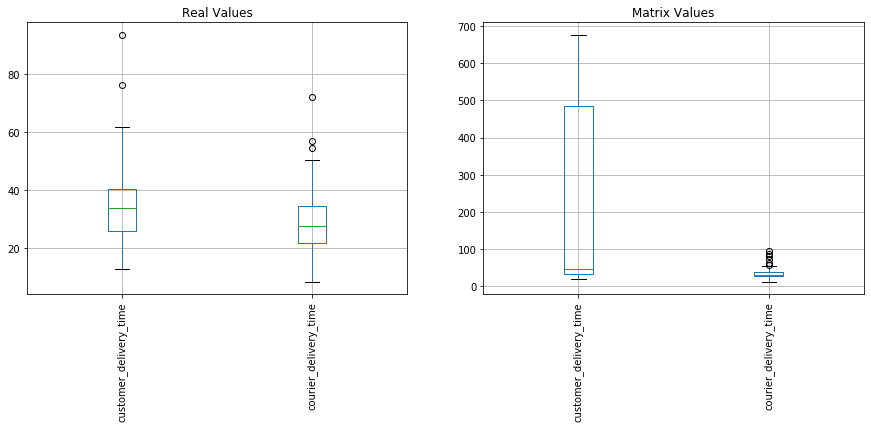

Real values: customer DT outliers


,order_id,customer_delivery_time,activation_to_first_stacking,first_stacking_to_courier_start,number_of_assignments
52,81911014,93.500000,0.850000,57.433333,2
19,81920850,76.316667,0.066667,4.066667,1
44,81921336,61.700000,0.966667,6.133333,1
50,81910472,57.316667,13.516667,9.166667,2
65,81908951,57.133333,0.116667,0.033333,1


Real values: courier DT outliers


,order_id,courier_delivery_time,activation_to_first_stacking,first_stacking_to_courier_start,start_to_pickup_time,waiting_pickup_time,pickup_to_delivery_time,waiting_delivery_time
19,81920850,72.133333,0.066667,4.066667,10.200000,51.400000,4.333333,6.183333
65,81908951,56.966667,0.116667,0.033333,24.566667,20.666667,9.300000,2.416667
44,81921336,54.583333,0.966667,6.133333,26.850000,10.983333,7.983333,7.266667
105,81928502,50.516667,0.800000,0.016667,1439.983333,38.366667,8.983333,3.150000
82,81902218,47.633333,0.350000,0.016667,16.150000,8.900000,17.950000,4.616667


In [155]:
real_dt.columns

fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize=(15,5))
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=None)
real_dt.boxplot(column=['customer_delivery_time', 'courier_delivery_time'], ax = ax1, rot = 90)
ax1.set_title('Real Values')

sim_dt.boxplot(column=['customer_delivery_time', 'courier_delivery_time'], ax = ax2, rot = 90)
ax2.set_title('Matrix Values')
plt.show()


outlier_validation_metrics = ['order_id', 'customer_delivery_time', 'activation_to_first_stacking', 
                              'first_stacking_to_courier_start', 'number_of_assignments']
print('Real values: customer DT outliers')
display(real_dt[outlier_validation_metrics].sort_values('customer_delivery_time', ascending = False).head(5))



outlier_validation_metrics = ['order_id', 'courier_delivery_time', 'activation_to_first_stacking',
                              'first_stacking_to_courier_start', 'start_to_pickup_time', 'waiting_pickup_time',
                              'pickup_to_delivery_time', 'waiting_delivery_time']
print('Real values: courier DT outliers')
display(real_dt[outlier_validation_metrics].sort_values('courier_delivery_time', ascending = False).head(5))

real_dt_original = real_dt

real_dt_reassignments = real_dt[real_dt.number_of_assignments > 1]
real_dt = real_dt[real_dt.number_of_assignments == 1]


waiting_delivery_time_boundary = real_dt.waiting_delivery_time.quantile(0.75) + 3 * iqr(real_dt.waiting_delivery_time)

real_dt_wtd_outlier = real_dt[real_dt.waiting_delivery_time > waiting_delivery_time_boundary]
real_dt = real_dt[real_dt.waiting_delivery_time <= waiting_delivery_time_boundary]



waiting_pickup_time_boundary = real_dt.waiting_pickup_time.quantile(0.75) + 3 * iqr(real_dt.waiting_pickup_time)

real_dt_wtp_outlier = real_dt[real_dt.waiting_pickup_time > waiting_pickup_time_boundary]
real_dt = real_dt[real_dt.waiting_pickup_time <= waiting_pickup_time_boundary]


dispatch_to_accept_time_boundary = real_dt.partner_dispatch_to_accept.quantile(0.75) + 3 * iqr(real_dt.partner_dispatch_to_accept)

real_dt_disp_to_accept_outlier = real_dt[real_dt.partner_dispatch_to_accept > dispatch_to_accept_time_boundary]
real_dt = real_dt[real_dt.partner_dispatch_to_accept <= dispatch_to_accept_time_boundary]

# sp distance
sp_distance_boundary = real_dt.start_to_pickup_distance.quantile(0.75) + 3 * iqr(real_dt.start_to_pickup_distance)

real_dt_sp_distance_outlier = real_dt[real_dt.start_to_pickup_distance > sp_distance_boundary]
real_dt = real_dt[real_dt.start_to_pickup_distance <= sp_distance_boundary]

## Cleaning outliers

For the moment, we have applied the following criterias to detect outliers, caused by phenomenas that we are not considering in our simulation. 

1. Orders that have been reassigned. 
2. Orders that have a waiting at pickup time higher than 3Q + 3IQR. 
3. Orders that have a waiting at delivery time higher than 3Q + 3IQR. 

These are quite conservative criterias. The number of cleaned orders by each of the criterias is the following:

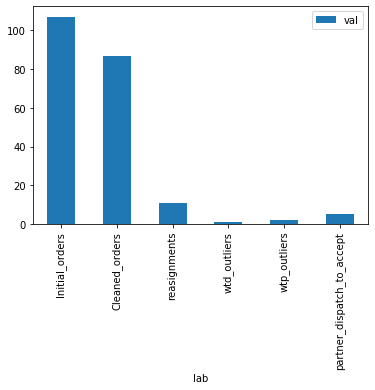

In [156]:

df = pd.DataFrame({'lab':['Initial_orders', 'Cleaned_orders', 'reasignments', 'wtd_outliers', 'wtp_outliers',
                         'partner_dispatch_to_accept'], 
                   'val':[len(real_dt_original), len(real_dt), len(real_dt_reassignments),
                          len(real_dt_wtd_outlier),len(real_dt_wtp_outlier), len(real_dt_disp_to_accept_outlier)]})

ax = df.plot.bar(x='lab', y='val', rot=90)




## Data after outlier cleansing

In [157]:

outlier_validation_metrics = ['order_id', 'customer_delivery_time', 'activation_to_first_stacking', 'first_stacking_to_courier_start', 'number_of_assignments']
display(real_dt[outlier_validation_metrics].sort_values('customer_delivery_time', ascending = False).head(5))


outlier_validation_metrics = ['order_id', 'courier_delivery_time', 'activation_to_first_stacking', 'first_stacking_to_courier_start', 'start_to_pickup_time', 'waiting_pickup_time', 'pickup_to_delivery_time', 'waiting_delivery_time']
print('Real values: courier DT outliers')
display(real_dt[outlier_validation_metrics].sort_values('courier_delivery_time', ascending = False).head(5))



,order_id,customer_delivery_time,activation_to_first_stacking,first_stacking_to_courier_start,number_of_assignments
44,81921336,61.700000,0.966667,6.133333,1
65,81908951,57.133333,0.116667,0.033333,1
31,81904275,56.383333,0.100000,27.516667,1
73,81844788,56.216667,25.550000,0.016667,1
95,81846119,55.550000,9.850000,0.016667,1


Real values: courier DT outliers


,order_id,courier_delivery_time,activation_to_first_stacking,first_stacking_to_courier_start,start_to_pickup_time,waiting_pickup_time,pickup_to_delivery_time,waiting_delivery_time
65,81908951,56.966667,0.116667,0.033333,24.566667,20.666667,9.300000,2.416667
44,81921336,54.583333,0.966667,6.133333,26.850000,10.983333,7.983333,7.266667
82,81902218,47.633333,0.350000,0.016667,16.150000,8.900000,17.950000,4.616667
13,81908950,46.300000,0.133333,4.083333,17.933333,20.166667,4.733333,3.450000
95,81846119,45.650000,9.850000,0.016667,16.300000,14.416667,9.383333,5.533333


## Incidents

In [158]:
# FILTER OUR INCIDENTS

incidents_summary = pd.read_csv("reality_data/incidences_summary_SEV_2019-12-01_2019-12-01.csv")
incidents_orders = pd.read_csv("reality_data/incidences_orders_SEV_2019-12-01_2019-12-01.csv")
                        

In [159]:
orders_intersection = pd.merge(incidents_orders[['order_id']], real_dt[['order_id']], how='inner')
orders_intersection = pd.merge(orders_intersection, sim_dt[['order_id']], how='inner')

#print("Number of common orders in matrix and reality:", len(orders_intersection))

#We keep only orders that are found on both matrix and reality.
sim_dt = pd.merge(sim_dt, orders_intersection, on = 'order_id', how = 'inner')
real_dt = pd.merge(real_dt, orders_intersection, on = 'order_id', how = 'inner')

In [160]:

real_dt_with_incidents = pd.merge(real_dt, incidents_orders, on = 'order_id', how = 'left')
real_dt = real_dt_with_incidents.loc[real_dt_with_incidents["Any_problem"]==False]

In [161]:
incidents_summary

,Order Type,val
0,Total,2789
1,Cancelled,484
2,Delivered,2305
3,Reassigned,164
4,Manual_Assignment,40
5,Orphan,69
6,Cancelled Reassignments,31
7,Orders_without_incidences,2067



# Customer Delivery Time

We will start by taking a look at the deviation of the CDT. At the same time, we will try which of the components of the CDT are the ones that have the biggest deviation. 

## Daily aggregation


In [162]:
def plot_time_comp_distr_and_hours(real_dt, sim_dt, metric):

    # check if dataframes non empty
    if len(real_dt)==0:
        print("Real data is empty")
        return
    if len(sim_dt)==0:
        print("Sim data is empty")
        return
    
    real_no_outl, real_outl = detect_outliers(real_dt[metric], q1, q2, th)
    sim_no_outl, sim_outl = detect_outliers(sim_dt[metric], q1, q2, th)

    ## compute statistics
    row_real = get_statistics(real_no_outl, real_outl, "real", q1, q2)
    row_sim = get_statistics(sim_no_outl, sim_outl, "sim", q1, q2)
    
    diff_activation_time = get_overall_distr_by_hour(metric)
    
    
    # plot distributions
    fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(15,5))
    fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.5, hspace=None)
    
    ax1.set_title(metric)
    ax1.hist(real_no_outl, bins=30, label='real', alpha=0.5, density= True)
    ax1.hist(sim_no_outl, bins=30, color='r', label='simulation', alpha=0.5, density= True)
    #ax1.set_xlim((min(min(real_no_outl), min(sim_no_outl)), max(max(real_no_outl), max(sim_no_outl))))
    ax1.legend()
    ax1.set_xlabel("time[min]")
    
    ax2.plot(diff_activation_time["activation_time_hour"], diff_activation_time["diff"], label=metric)
    ax2.set_xticks(diff_activation_time["activation_time_hour"])
    ax2.set_xlabel("hour")
    ax2.set_ylabel("difference (simulation - real) [min]")
    ax2.set_title("Difference between simulation and real data by hour")
    ax2.grid()
    ax2.legend()
    plt.show()

    
    # compute ks test
    kstat, p_value = ks_2samp(sim_no_outl, real_no_outl)
    print("p-value = %.2f" %p_value)

    # print the difference between mean of two distributions
    print_avg_diff(real_no_outl, sim_no_outl)

    # print statistics
    row_sim.append(row_real)

In [163]:
def plot_dist_comp_distr_and_hours(metric):

    
    real_no_outl, real_outl = detect_outliers(real_dt[metric], q1, q2, th)
    sim_no_outl, sim_outl = detect_outliers(sim_dt[metric], q1, q2, th)

    ## compute statistics
    row_real = get_statistics(real_no_outl, real_outl, "real", q1, q2)
    row_sim = get_statistics(sim_no_outl, sim_outl, "sim", q1, q2)
    
    diff_activation_time = get_overall_distr_by_hour(metric)
    
    
    # plot distributions
    fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(15,5))
    fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.5, hspace=None)
    
    ax1.set_title(metric)
    ax1.hist(real_no_outl, bins=30, label='real', alpha=0.5, density= True)
    ax1.hist(sim_no_outl, bins=30, color='r', label='simulation', alpha=0.5, density= True)
    ax1.set_xlim((min(min(real_no_outl), min(sim_no_outl)), max(max(real_no_outl), max(sim_no_outl))))
    ax1.legend()
    ax1.set_xlabel("distance[m]")
    
    ax2.plot(diff_activation_time["activation_time_hour"], diff_activation_time["diff"], label=metric)
    ax2.set_xticks(diff_activation_time["activation_time_hour"])
    ax2.set_xlabel("hour")
    ax2.set_ylabel("difference (simulation - real) [m]")
    ax2.set_title("Difference between simulation and real data by hour")
    ax2.grid()
    ax2.legend()
    plt.show()

    
    # compute ks test
    kstat, p_value = ks_2samp(sim_no_outl, real_no_outl)
    print("p-value = %.2f" %p_value)

    # print the difference between mean of two distributions
    print_avg_diff_dist(real_no_outl, sim_no_outl)

    # print statistics
    row_sim.append(row_real)

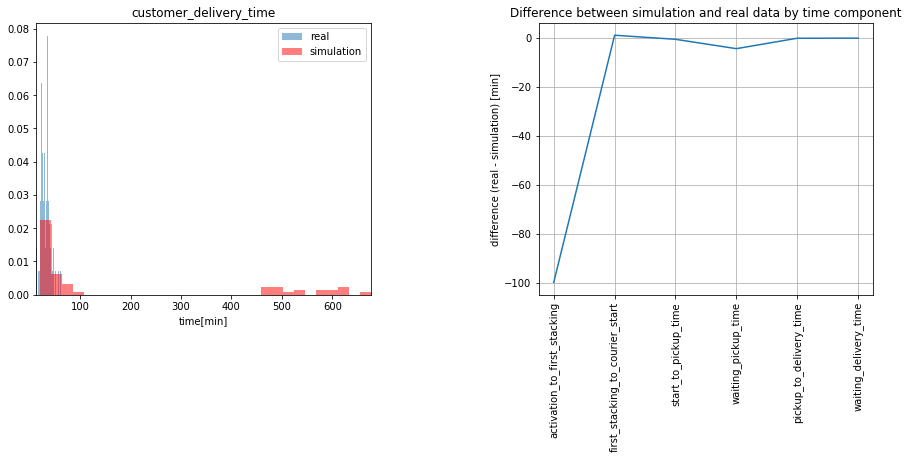

p-value = 0.00


$\Delta \mu = -154.65$ min [real - simulation]

,mean,std,outliers no,outliers %,q15,q85
sim,187.24,234.23,0,0.0,29.20,532.18
real,32.59,10.07,0,0.0,22.89,43.06


,activation_to_first_stacking,first_stacking_to_courier_start,start_to_pickup_time,waiting_pickup_time,pickup_to_delivery_time,waiting_delivery_time
real,1.851149,3.018966,9.703640,6.340230,8.515709,2.968199
sim,101.745019,1.942529,10.294177,10.747585,8.670106,3.086441
diff,-99.893870,1.076437,-0.590537,-4.407355,-0.154397,-0.118241


In [164]:
def plot_distr_by_day_with_comps(col, components):
    # plot by day

    # compute mean differences for each of the components metrics. 
    
    avg_diff = []
    for metric in components:
        diff =  real_dt.loc[:, metric].mean() - sim_dt.loc[:, metric].mean() 
        avg_diff.append(diff)

    # set percentiles
    q1 = 15
    q2 = 85

    # identify outliers
    real_no_outl, real_outl = detect_outliers(real_dt[col], q1, q2, 1.8)
    sim_no_outl, sim_outl = detect_outliers(sim_dt[col], q1, q2, 1.8)

    # compute statistics
    row_real = get_statistics(real_no_outl, real_outl, "real", q1, q2)
    row_sim = get_statistics(sim_no_outl, sim_outl, "sim", q1, q2)

    
    fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(15,5))
    fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.5, hspace=None)
    
    # plot distributions
    ax1.hist(real_no_outl, bins=30, label='real', alpha=0.5, density=True)
    ax1.hist(sim_no_outl, bins=30, color='r', label='simulation', alpha=0.5, density= True)
    ax1.set_xlim((min(min(real_no_outl), min(sim_no_outl)), max(max(real_no_outl), max(sim_no_outl))))
    ax1.legend()
    ax1.set_xlabel("time[min]")
    ax1.set_title(col)
 
    

    ax2.plot(np.arange(len(avg_diff)), avg_diff)
    ax2.set_xticks(np.arange(len(avg_diff)))
    ax2.set_xticklabels(components, rotation='vertical')
    ax2.set_ylabel("difference (real - simulation) [min]")
    ax2.set_title("Difference between simulation and real data by time component")
    ax2.grid()
    
    plt.show()

    # compute ks test
    kstat, p_value = ks_2samp(sim_no_outl, real_no_outl)
    print("p-value = %.2f" %p_value)

    # print the difference between mean of two distributions
    print_avg_diff(real_dt[col], sim_dt[col])
    
    # print statistics
    display(row_sim.append(row_real))
    
    

    
plot_distr_by_day_with_comps(time, time_components)

real_means = real_dt[time_components].apply(np.mean, axis = 0)
sim_means = sim_dt[time_components].apply(np.mean, axis = 0)
summary_real_sim = pd.DataFrame({'real': real_means, 'sim':sim_means})
summary_real_sim['diff'] = summary_real_sim.real - summary_real_sim.sim
summary_real_sim = summary_real_sim.T

summary_real_sim = summary_real_sim[['activation_to_first_stacking', 'first_stacking_to_courier_start',
       'start_to_pickup_time', 'waiting_pickup_time','pickup_to_delivery_time',
        'waiting_delivery_time']]


display(summary_real_sim)



In [165]:
sim_dt.head()

,activation_time,courier_starts_order,order_id,partner_dispatch_to_enter_pickup,activation_to_partner_dispatch,waiting_delivery_time,pickup_to_delivery_time,food_getting_cold,waiting_pickup_time,start_to_pickup_time,last_stacking_to_courier_start,first_stacking_to_last_stacking,activation_to_first_stacking,customer_delivery_time,courier_delivery_time,prioritized_pickup,start_to_pickup_distance,first_stacking_to_courier_start,activation_time_date,activation_time_hour
0,1900-01-01 00:00:31,09:52:00,81844642.0,1181.0,39089.0,0.933333,5.016667,0.0,0.000000,79.683333,0.0,0.0,591.483333,677.116667,85.633333,False,200,0.0,1900-01-01,0
1,1900-01-01 00:01:32,08:35:00,81844788.0,862.0,30301.0,2.616667,12.716667,0.0,0.633333,5.916667,720.0,0.0,501.466667,535.350000,21.883333,False,200,12.0,1900-01-01,0
2,1900-01-01 00:03:47,00:08:00,81845121.0,503.0,253.0,3.266667,10.333333,0.0,6.616667,8.383333,0.0,0.0,4.216667,32.816667,28.600000,False,200,0.0,1900-01-01,0
3,1900-01-01 00:05:41,09:58:00,81845420.0,731.0,36096.0,4.350000,8.683333,25.0,0.000000,21.466667,720.0,0.0,580.316667,626.816667,34.500000,False,200,12.0,1900-01-01,0
4,1900-01-01 00:06:17,09:47:00,81845509.0,900.0,35541.0,2.483333,5.016667,0.0,0.000000,26.633333,0.0,0.0,580.716667,614.850000,34.133333,False,200,0.0,1900-01-01,0


In [166]:
real_dt.head()

,Unnamed: 0,order_id,city_code,courier_id,activation_time,activation_time_local,pickup,delivery,is_food,is_marketplace,partner_order,order_category,number_of_assignments,waiting_pickup_time,store_address_id,transport,category,final_status_x,delivery_latitude,delivery_longitude,pickup_latitude,pickup_longitude,point_creation_time,entering_delivery,entering_pickup,first_stacking,last_stacking,courier_start_latitude,courier_start_longitude,courier_start_local,courier_start,partner_dispatch,partner_accepted,store_id,prioritized_pickup,courier_delivery_time,customer_delivery_time,start_to_pickup_time,pickup_to_delivery_time,waiting_delivery_time,activation_to_partner_dispatch,partner_dispatch_to_enter_pickup,partner_dispatch_to_accept,activation_to_first_stacking,first_stacking_to_last_stacking,last_stacking_to_courier_start,pickup_to_delivery_distance,start_to_pickup_distance,first_stacking_to_courier_start,activation_time_date,activation_time_hour,final_status_y,reassigned,manual_assingment,orphan,cancelled_reassignment,Any_problem
0,0,81901831,SEV,4025483.0,2019-12-01 07:25:41,2019-12-01 08:25:41.000,2019-12-01 07:42:18.706,2019-12-01 08:01:13.000,True,False,True,WALL - Partner,1,2.183333,23869.0,BICYCLE,MCDONALDS,DeliveredStatus,37.370790,-5.972510,37.391863,-5.975339,2019-12-01 07:25:40.000,2019-12-01 07:56:30.000,2019-12-01 07:40:07.000,2019-12-01 07:26:04.819,2019-12-01 07:26:04.819,37.392679,-5.970318,2019-12-01 08:26:06.071,2019-12-01 07:26:06.071,2019-12-01 07:26:15.000,2019-12-01 07:27:18.000,23869.0,False,35.100000,35.533333,14.000000,14.183333,4.716667,34,832,63,0.383333,0,1,2356.508537,452.739021,0.016667,2019-12-01,7,DeliveredStatus,False,False,False,False,False
1,1,81907294,SEV,12032938.0,2019-12-01 09:03:18,2019-12-01 10:03:18.000,2019-12-01 09:26:47.081,2019-12-01 09:36:28.000,True,False,True,WALL - Partner,1,6.433333,5029.0,MOTORBIKE,SNACK_IBERIA,DeliveredStatus,37.397680,-5.980350,37.394786,-5.991559,2019-12-01 09:03:17.000,2019-12-01 09:32:07.000,2019-12-01 09:20:20.000,2019-12-01 09:03:42.544,2019-12-01 09:03:42.544,37.388025,-6.001247,2019-12-01 10:03:43.430,2019-12-01 09:03:43.430,2019-12-01 09:03:55.000,2019-12-01 09:05:15.000,5029.0,False,32.733333,33.166667,16.600000,5.316667,4.350000,37,985,80,0.400000,0,0,1041.193017,1139.183308,0.000000,2019-12-01,9,DeliveredStatus,False,False,False,False,False
2,2,81926966,SEV,9126179.0,2019-12-01 11:47:18,2019-12-01 12:47:18.000,2019-12-01 12:14:12.747,2019-12-01 12:23:40.000,True,False,True,WALL - Partner,1,5.800000,68868.0,MOTORBIKE,MCDONALDS,DeliveredStatus,37.364153,-6.076765,37.378483,-6.082777,2019-12-01 11:47:17.000,2019-12-01 12:20:50.000,2019-12-01 12:08:24.000,2019-12-01 11:47:30.382,2019-12-01 11:48:31.609,37.374822,-5.999863,2019-12-01 12:55:39.246,2019-12-01 11:55:39.246,2019-12-01 11:58:55.000,2019-12-01 11:59:36.000,68868.0,True,28.000000,36.366667,12.733333,6.616667,2.833333,697,569,41,0.200000,61,427,1679.715036,7337.838725,8.133333,2019-12-01,11,DeliveredStatus,False,False,False,False,False
3,90,81906523,SEV,4025483.0,2019-12-01 08:52:50,2019-12-01 09:52:50.000,2019-12-01 09:10:47.316,2019-12-01 09:24:53.000,True,False,True,WALL - Partner,1,3.166667,12038.0,BICYCLE,SNACK_IBERIA,DeliveredStatus,37.376990,-6.005643,37.390365,-5.999953,2019-12-01 08:52:49.000,2019-12-01 09:20:57.000,2019-12-01 09:07:37.000,2019-12-01 08:53:32.799,2019-12-01 08:53:32.799,37.386569,-6.008723,2019-12-01 09:57:38.871,2019-12-01 08:57:38.871,2019-12-01 08:53:43.000,2019-12-01 08:56:32.000,12038.0,False,27.233333,32.050000,9.966667,10.150000,3.933333,53,834,169,0.700000,0,246,1569.957046,882.288803,4.100000,2019-12-01,8,DeliveredStatus,False,False,False,False,False
4,133,81912551,SEV,23067043.0,2019-12-01 10:02:27,2019-12-01 11:02:27.000,2019-12-01 10:24:15.613,2019-12-01 10:37:02.000,True,False,True,WALL - Partner,1,10.916667,5029.0,BICYCLE,SNACK_IBERIA,DeliveredStatus,37.407810,-5.986971,37.394786,-5.991559,2019-12-01 10:02:27.000,2019-12-01 10:33:45.000,2019-12-01 10:13:2

## Analysis by order category

In [202]:
# faked pp flag
sim_dt['order_category'] = 'WALL - Partner'

In [203]:
# add order category based on reality data 
sim_dt = pd.merge(sim_dt, real_dt[["order_id", "prioritized_pickup"]].drop_duplicates(),
                 how="left", on="order_id")

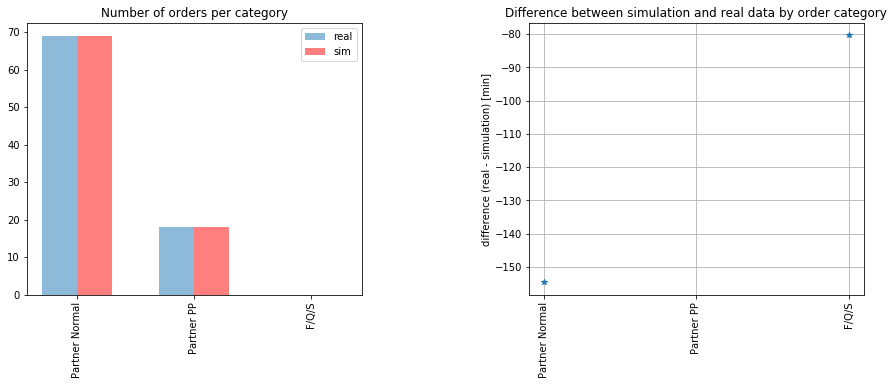

In [204]:
def plot_distr_by_day_with_order_category(col, components):
    
    # compute number of orders per category
   
    
    r_partner=real_dt.loc[real_dt['order_category'] == 'WALL - Partner']["order_id"].count()
    r_fqs=real_dt.loc[(real_dt['order_category'] == "WALL - NonPartner") |
                      (real_dt['order_category'] == "COURIER") |
                      (real_dt['order_category'] == "QUIERO")]["order_id"].count()
    r_pp=real_dt.loc[(real_dt['prioritized_pickup'] == True)]["order_id"].count()
    
    orders_real_count = pd.DataFrame({'Partner Normal': r_partner - r_pp,
                                                   'Partner PP': r_pp,
                                                  'F/Q/S': r_fqs}, 
                                    index=[0])
 
    s_partner=sim_dt.loc[sim_dt['order_category'] == 'WALL - Partner']["order_id"].count()
    s_fqs=sim_dt.loc[(sim_dt['order_category'] == "WALL - NonPartner") |
                      (sim_dt['order_category'] == "COURIER") |
                      (sim_dt['order_category'] == "QUIERO")]["order_id"].count()
    s_pp=sim_dt.loc[(sim_dt['prioritized_pickup'] == True)]["order_id"].count()
    
    orders_sim_count = pd.DataFrame({'Partner Normal': s_partner - s_pp,
                                                   'Partner PP': s_pp,
                                                  'F/Q/S': s_fqs},
                                   index=[0])
    
    
    fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(15,5))
    fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.5, hspace=None)
    
    # plot distributions
    x = np.arange(orders_real_count.shape[1])  # the label locations
    width = 0.3  # the width of the bars

    rects1 = ax1.bar(x - width/2, orders_real_count.values[0], width, alpha=0.5, label='real')
    rects2 = ax1.bar(x + width/2, orders_sim_count.values[0], width, color='r', alpha=0.5, label='sim')

    # Add some text for labels, title and custom x-axis tick labels, etc.

    ax1.set_xticks(x)
    ax1.set_xticklabels(orders_real_count.columns, rotation='vertical')
    ax1.legend()
    
    #real_dt['order_category'].value_counts().plot(kind='bar', ax=ax1)
   # ax1.set_xlim((min(min(real_no_outl), min(sim_no_outl)), max(max(real_no_outl), max(sim_no_outl))))
    #ax1.set_xlabel("order category")
    ax1.set_title("Number of orders per category")
 
    # compute mean differences for each of the components metrics. 
    
    r_avg_partner=real_dt.loc[(real_dt['order_category'] == 'WALL - Partner')
                             | (real_dt['prioritized_pickup'] != True)][col].mean()
    r_avg_fqs=real_dt.loc[(real_dt['order_category'] == "WALL - NonPartner") |
                      (real_dt['order_category'] == "COURIER") |
                      (real_dt['order_category'] == "QUIERO")][col].mean()
    r_pp=real_dt.loc[(real_dt['prioritized_pickup'] == True)][col].mean()
    
 
    s_avg_partner=sim_dt.loc[(sim_dt['order_category'] == 'WALL - Partner')
                             | (sim_dt['prioritized_pickup'] != True)][col].mean()
    s_avg_fqs=sim_dt.loc[(sim_dt['order_category'] == "WALL - NonPartner") |
                      (sim_dt['order_category'] == "COURIER") |
                      (sim_dt['order_category'] == "QUIERO")][col].mean()
    s_pp=sim_dt.loc[(sim_dt['prioritized_pickup'] == True)][col].mean()
    

    avg_diff = [r_avg_partner - s_avg_partner, r_avg_fqs - s_avg_fqs, r_pp - s_pp]
    ax2.plot(np.arange(len(avg_diff)), avg_diff, "*")
    ax2.set_xticks(np.arange(len(avg_diff)))
    ax2.set_xticklabels(orders_real_count.columns, rotation='vertical')
    ax2.set_ylabel("difference (real - simulation) [min]")
    ax2.set_title("Difference between simulation and real data by order category")
    ax2.grid()
    
    plt.show()

category_list = ["Partner", "F/Q/S", "prioritized_pickup"]

plot_distr_by_day_with_order_category("customer_delivery_time", category_list)


### Partner Orders Normal (non PP)

In [205]:
sim_dt["order_category"] = 'WALL - Partner'

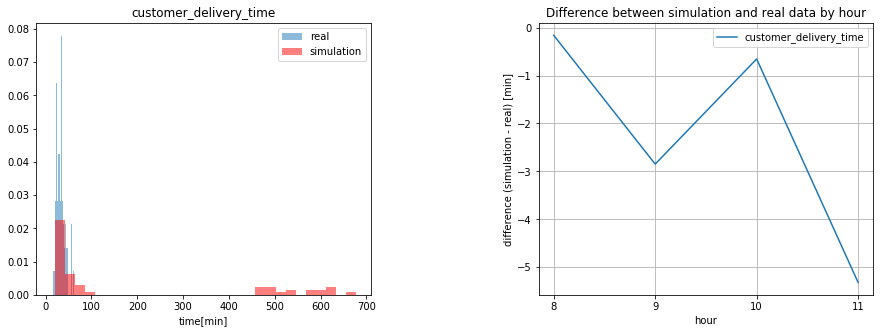

p-value = 0.00


$\Delta \mu = -154.65$ min [real - simulation]

In [206]:
#percentiles
q1 = 10
q2 = 90
th = 2
   
real_dt_partner=real_dt.loc[(real_dt['order_category'] == 'WALL - Partner')
                             | (real_dt['prioritized_pickup'] != True)]
sim_dt_partner=sim_dt.loc[(sim_dt['order_category'] == 'WALL - Partner')
                             | (sim_dt['prioritized_pickup'] != True)]

plot_time_comp_distr_and_hours(real_dt_partner, sim_dt_partner, 'customer_delivery_time')

### Partner Orders Prioritized Pickup

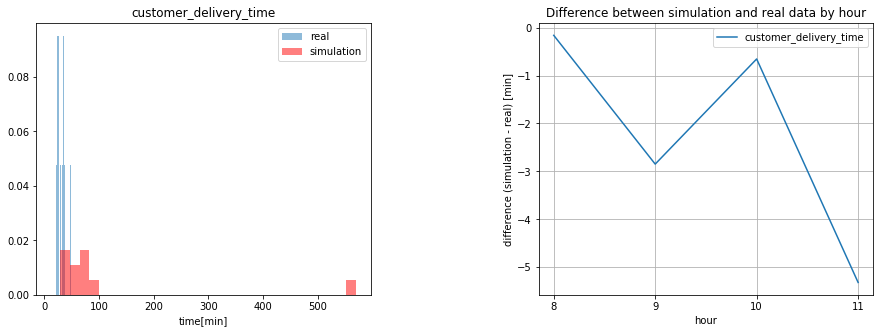

p-value = 0.00


$\Delta \mu = -80.37$ min [real - simulation]

In [207]:
#percentiles
q1 = 5
q2 = 95
th = 2
   
real_dt_pp=real_dt.loc[real_dt['prioritized_pickup'] == True]
sim_dt_pp=sim_dt.loc[sim_dt['prioritized_pickup'] == True]

plot_time_comp_distr_and_hours(real_dt_pp, sim_dt_pp, 'customer_delivery_time')

### Fake/Quiero/Shipment

In [208]:
#percentiles
q1 = 5
q2 = 95
th = 2

    
real_dt_fqs=real_dt.loc[(real_dt['order_category'] == "WALL - NonPartner") |
                      (real_dt['order_category'] == "COURIER") |
                      (real_dt['order_category'] == "QUIERO")]
  
sim_dt_fqs=sim_dt.loc[(sim_dt['order_category'] == "WALL - NonPartner") |
                      (sim_dt['order_category'] == "COURIER") |
                      (sim_dt['order_category'] == "QUIERO")]

plot_time_comp_distr_and_hours(real_dt_fqs, sim_dt_fqs, 'customer_delivery_time')

Real data is empty


## Customer DT components analysis

In this section, we will look at each of the components of the CDT

### Activation to first stacked

#### General overview



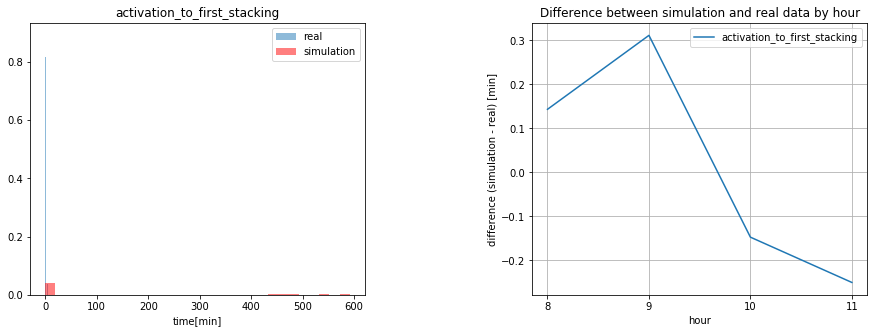

p-value = 0.02


$\Delta \mu = -100.17$ min [real - simulation]

In [194]:
#percentiles
q1 = 10
q2 = 90
th = 2

plot_time_comp_distr_and_hours(real_dt, sim_dt,'activation_to_first_stacking')

#### Edge cases review

In [195]:
fields = ['order_id', 'activation_to_first_stacking', 'activation_time']

#sim_dt.columns

sim_real_activation_first_stack = pd.merge(real_dt[fields], sim_dt[fields], how = "inner", on = "order_id")
sim_real_activation_first_stack['sim_real_activation_first_stack_gap'] = sim_real_activation_first_stack.activation_to_first_stacking_x - sim_real_activation_first_stack.activation_to_first_stacking_y

sim_real_activation_first_stack = sim_real_activation_first_stack.sort_values('sim_real_activation_first_stack_gap', ascending = False)

sim_real_activation_first_stack.head(10)

,order_id,activation_to_first_stacking_x,activation_time_x,activation_to_first_stacking_y,activation_time_y,sim_real_activation_first_stack_gap
10,81910652,9.500000,2019-12-01 09:41:59,0.016667,1900-01-01 10:41:59,9.483333
15,81918109,9.350000,2019-12-01 10:51:20,0.666667,1900-01-01 11:51:20,8.683333
61,81927615,4.183333,2019-12-01 11:50:26,0.566667,1900-01-01 12:50:26,3.616667
42,81846132,5.650000,2019-11-30 23:10:15,2.750000,1900-01-01 00:10:15,2.900000
56,81909688,2.800000,2019-12-01 09:31:24,0.600000,1900-01-01 10:31:24,2.200000
26,81929299,2.116667,2019-12-01 11:58:37,0.383333,1900-01-01 12:58:37,1.733333
17,81929197,2.666667,2019-12-01 11:58:04,0.933333,1900-01-01 12:58:04,1.733333
36,81921336,0.966667,2019-12-01 11:13:59,0.016667,1900-01-01 12:13:59,0.950000
41,81913234,0.866667,2019-12-01 10:08:55,0.083333,1900-01-01 11:08:55,0.783333
50,81912601,0.716667,2019-12-01 10:02:58,0.033333,1900-01-01 11:02:58,0.683333


### First stacked to started

#### General overview


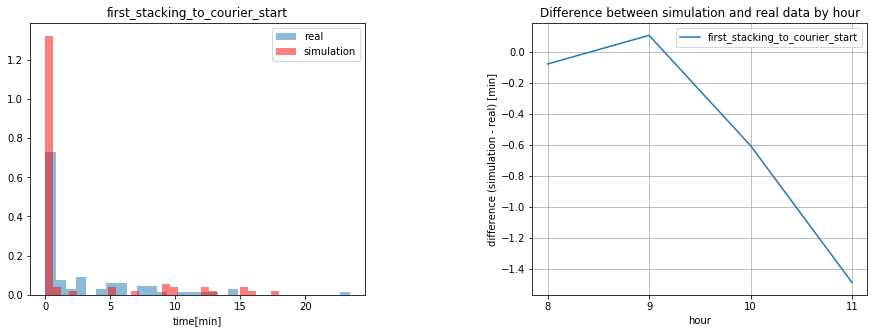

p-value = 0.00


$\Delta \mu = 0.79$ min [real - simulation]

In [196]:

#percentiles
q1 = 10
q2 = 90
th = 2

plot_time_comp_distr_and_hours(real_dt, sim_dt,'first_stacking_to_courier_start')



#### Edge cases review

In [197]:
fields = ['order_id', 'first_stacking_to_courier_start']

#sim_dt.columns

sim_real_first_stack_courier_start = pd.merge(real_dt[fields], sim_dt[fields], how = "inner", on = "order_id")
sim_real_first_stack_courier_start['sim_real_first_stacking_courier_start_gap'] = sim_real_first_stack_courier_start.first_stacking_to_courier_start_x - sim_real_first_stack_courier_start.first_stacking_to_courier_start_y

sim_real_first_stack_courier_start = sim_real_first_stack_courier_start.sort_values('sim_real_first_stacking_courier_start_gap', ascending = False)


display(sim_real_first_stack_courier_start.head(10))
display(sim_real_first_stack_courier_start.tail(10))

real_dt.first_stacking_to_courier_start.describe()

,order_id,first_stacking_to_courier_start_x,first_stacking_to_courier_start_y,sim_real_first_stacking_courier_start_gap
82,81917724,23.433333,0.0,23.433333
25,81904275,27.516667,10.0,17.516667
27,81920193,14.250000,0.0,14.250000
63,81917536,14.233333,0.0,14.233333
77,81927461,13.216667,0.0,13.216667
23,81927648,12.200000,0.0,12.200000
86,81893148,11.166667,0.0,11.166667
69,81928576,10.166667,0.0,10.166667
39,81918248,9.166667,0.0,9.166667
61,81927615,8.150000,0.0,8.150000


,order_id,first_stacking_to_courier_start_x,first_stacking_to_courier_start_y,sim_real_first_stacking_courier_start_gap
66,81902218,0.016667,9.0,-8.983333
16,81848731,0.016667,9.0,-8.983333
80,81848717,0.000000,9.0,-9.000000
71,81845420,0.016667,12.0,-11.983333
59,81844788,0.016667,12.0,-11.983333
70,81845742,0.016667,13.0,-12.983333
9,81904756,0.016667,15.0,-14.983333
49,81850452,0.000000,15.0,-15.000000
0,81901831,0.016667,16.0,-15.983333
78,81846119,0.016667,18.0,-17.983333


count    87.000000
mean      3.018966
std       5.129776
min       0.000000
25%       0.016667
50%       0.033333
75%       5.091667
max      27.516667
Name: first_stacking_to_courier_start, dtype: float64

### Started to enters pickup

#### General overview

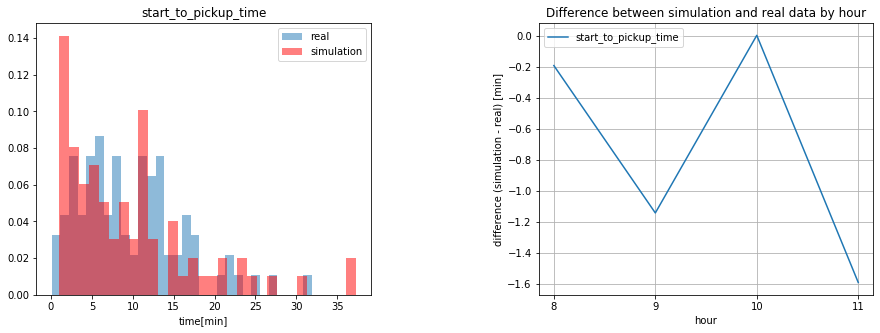

p-value = 0.32


$\Delta \mu = 0.26$ min [real - simulation]

In [198]:
#percentiles
q1 = 10
q2 = 90
th = 2

plot_time_comp_distr_and_hours(real_dt, sim_dt,'start_to_pickup_time')

#### Edge cases review

In [199]:
fields = ['order_id', 'start_to_pickup_time']

#sim_dt.columns

sim_real_start_to_pickup_time = pd.merge(real_dt[fields], sim_dt[fields], how = "inner", on = "order_id")
sim_real_start_to_pickup_time['sim_real_start_to_pickup_time_gap'] = \
sim_real_start_to_pickup_time.start_to_pickup_time_x - sim_real_start_to_pickup_time.start_to_pickup_time_y

sim_real_start_to_pickup_time= sim_real_start_to_pickup_time.sort_values('sim_real_start_to_pickup_time_gap', ascending = False)


display(sim_real_start_to_pickup_time.head(10))
display(sim_real_start_to_pickup_time.tail(10))

real_dt.start_to_pickup_time.describe()

,order_id,start_to_pickup_time_x,start_to_pickup_time_y,sim_real_start_to_pickup_time_gap
28,81915980,22.833333,3.500000,19.333333
12,81908950,17.933333,2.583333,15.350000
36,81921336,26.850000,11.683333,15.166667
32,81925728,17.816667,3.000000,14.816667
45,81919879,17.683333,3.950000,13.733333
33,81926385,12.900000,1.633333,11.266667
77,81927461,15.233333,3.966667,11.266667
1,81907294,16.600000,5.416667,11.183333
55,81925119,11.850000,1.016667,10.833333
31,81927301,13.333333,2.700000,10.633333


,order_id,start_to_pickup_time_x,start_to_pickup_time_y,sim_real_start_to_pickup_time_gap
83,81925485,5.250000,19.466667,-14.216667
80,81848717,7.233333,23.566667,-16.333333
14,81846239,13.050000,37.000000,-23.950000
42,81846132,2.766667,30.066667,-27.300000
10,81910652,7.533333,37.300000,-29.766667
22,81844642,31.916667,79.683333,-47.766667
17,81929197,0.116667,NaN,NaN
26,81929299,3.366667,NaN,NaN
64,81929213,22.333333,NaN,NaN
69,81928576,5.583333,NaN,NaN


count    87.000000
mean      9.703640
std       6.457349
min       0.083333
25%       4.916667
50%       8.266667
75%      13.125000
max      31.916667
Name: start_to_pickup_time, dtype: float64

#### SP distance

In [200]:
def calculate_velocity(df, time_col, dist_col):
    
    # calculate the velocity as distance/time
    df.loc[:, "velocity"] = df.loc[:, dist_col]/df.loc[:, time_col]
    
    # remove negative time predictions with <=0 s (cannot compute the velocity these cases )
    df.loc[:, "velocity"] = df.loc[:, "velocity"].where(df.loc[:, time_col] >5,0)
    df.loc[:, "velocity"] = df.loc[:, "velocity"].where(df.loc[:, dist_col] >1,0)
    df.loc[:, "velocity"] = df.loc[:, "velocity"].where(df.loc[:, "velocity"] < 3*10**5,0)
    
    return df.loc[:, "velocity"]
    

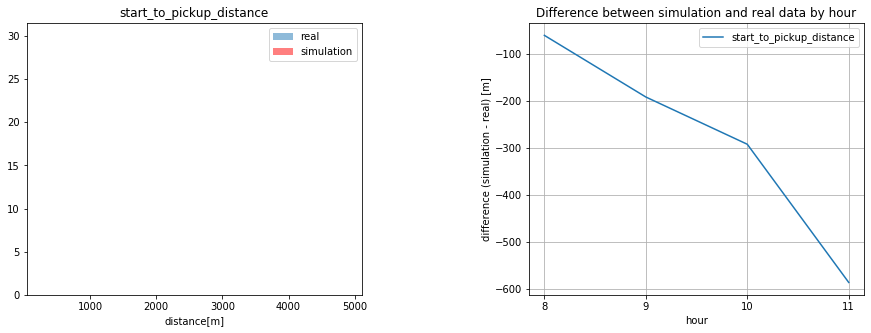

p-value = 0.00


$\Delta \mu = 1269.03$ m [real - simulation]

In [170]:
col = 'start_to_pickup_distance'

#percentiles
q1 = 10
q2 = 75
th = 2

plot_dist_comp_distr_and_hours(col)

#### SP velocity

Overall distribution of velocity computed as sp distance/sp time.

In [171]:
real_dt.loc[:, "sp_velocity"]= calculate_velocity(real_dt, "start_to_pickup_time", "start_to_pickup_distance")
sim_dt.loc[:, "sp_velocity"]= calculate_velocity(sim_dt, "start_to_pickup_time", "start_to_pickup_distance")


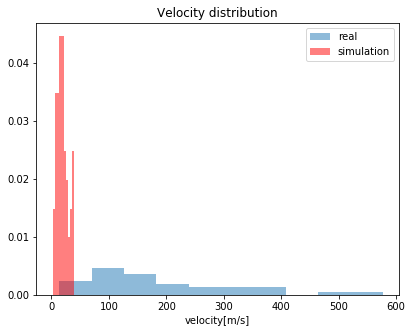

In [172]:

tmp = real_dt.copy()
tmp = tmp[tmp.velocity !=0]


data1 = tmp.loc[:, "start_to_pickup_distance"]
data2 = tmp.loc[:, "sp_velocity"]

tmp1 = sim_dt.copy()
tmp1 = tmp1[tmp1.velocity !=0]


# plot distributions

plt.subplots(figsize=(6.5,5))

plt.title("Velocity distribution")

plt.hist(tmp["sp_velocity"], label='real', alpha=0.5, density= True)
plt.hist(tmp1["sp_velocity"], color='r', label='simulation', alpha=0.5, density= True)
#ax.set_xlim((min(min(real_no_outl), min(sim_no_outl)), max(max(real_no_outl), max(sim_no_outl))))
plt.legend()
plt.xlabel("velocity[m/s]")
plt.show()


Below we check the dependence between velocity and distance. Comparing the real and simulation data we can check if we take into account the correlation during the simulation process.

No handles with labels found to put in legend.


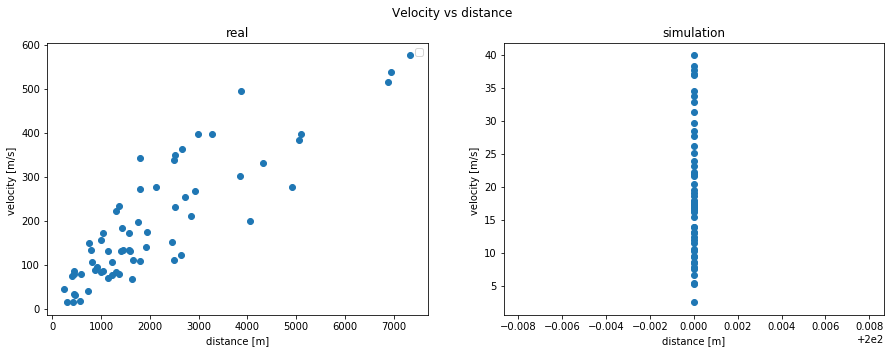

In [173]:
def create_colors_dict(data):
    c=["m","c","g","r","b"]
    colors = {}
    for transport in data["transport"].unique():
        colors[transport] = c.pop()
    return colors
    
colors=create_colors_dict(tmp)
# plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
plt.subplot(1,2,1)
plt.title("real")
plt.scatter(data1, data2)
#plt.scatter(data1, data2, c=tmp['transport'].apply(lambda x: colors[x]), 
#            label=list(tmp["transport"].unique()))
#plt.legend(list(tmp["transport"].unique()))

plt.legend()

plt.xlabel("distance [m]")
plt.ylabel("velocity [m/s] ")

data1 = tmp1.loc[:, "start_to_pickup_distance"]
data2 = tmp1.loc[:, "sp_velocity"]

#colors=create_colors_dict(tmp1)
# plot
plt.subplot(1,2,2)
plt.title("simulation")
#plt.scatter(data1, data2, c=tmp1['transport'].apply(lambda x: colors[x]))
plt.scatter(data1, data2)
plt.xlabel("distance [m]")
plt.ylabel("velocity [m/s] ")
plt.suptitle("Velocity vs distance")
plt.show()

plt.show()

### Waiting time at pickup

#### General overview


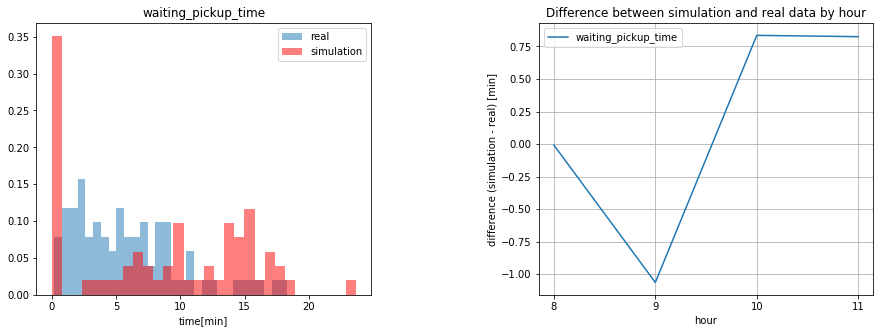

p-value = 0.00


$\Delta \mu = -2.8$ min [real - simulation]

In [174]:

#percentiles
q1 = 10
q2 = 75
th = 1.5

plot_time_comp_distr_and_hours(real_dt, sim_dt,'waiting_pickup_time')



#### Edge cases review

In [175]:
fields = ['order_id', 'waiting_pickup_time']

#sim_dt.columns

sim_real_waiting_pickup_time = pd.merge(real_dt[fields], sim_dt[fields], how = "inner", on = "order_id")
sim_real_waiting_pickup_time['sim_real_waiting_pickup_time_gap'] = \
sim_real_waiting_pickup_time.waiting_pickup_time_x - sim_real_waiting_pickup_time.waiting_pickup_time_y

sim_real_waiting_pickup_time= sim_real_waiting_pickup_time.sort_values('sim_real_waiting_pickup_time_gap', ascending = False)


display(sim_real_waiting_pickup_time.head(10))
display(sim_real_waiting_pickup_time.tail(10))

real_dt.waiting_pickup_time.describe()

,order_id,waiting_pickup_time_x,waiting_pickup_time_y,sim_real_waiting_pickup_time_gap
52,81908951,20.666667,0.000000,20.666667
70,81845742,19.916667,0.000000,19.916667
43,81909295,17.550000,0.466667,17.083333
78,81846119,14.416667,0.683333,13.733333
59,81844788,12.316667,0.633333,11.683333
83,81925485,9.166667,0.000000,9.166667
42,81846132,8.100000,0.000000,8.100000
74,81849545,7.050000,0.000000,7.050000
9,81904756,6.066667,0.050000,6.016667
81,81916070,15.383333,9.500000,5.883333


,order_id,waiting_pickup_time_x,waiting_pickup_time_y,sim_real_waiting_pickup_time_gap
47,81928009,5.483333,NaN,NaN
55,81925119,15.966667,NaN,NaN
57,81927950,3.550000,NaN,NaN
58,81928336,12.233333,NaN,NaN
61,81927615,3.366667,NaN,NaN
64,81929213,1.066667,NaN,NaN
69,81928576,0.883333,NaN,NaN
76,81923195,18.333333,NaN,NaN
77,81927461,4.133333,NaN,NaN
85,81922886,3.466667,NaN,NaN


count    87.000000
mean      6.340230
std       4.896686
min       0.200000
25%       2.400000
50%       5.483333
75%       8.483333
max      20.666667
Name: waiting_pickup_time, dtype: float64

### Pickup to delivery time

#### General overview

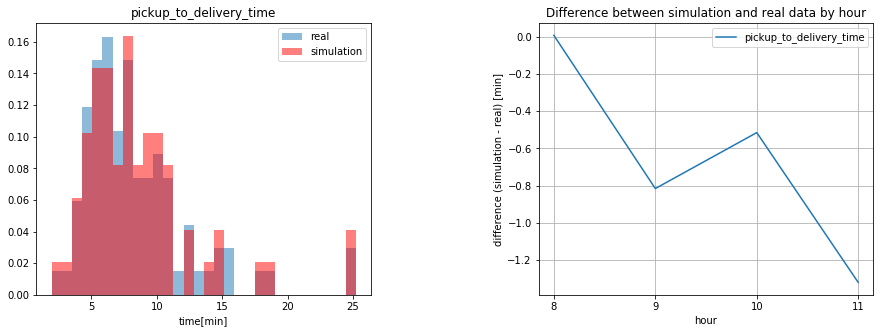

p-value = 1.00


$\Delta \mu = -0.15$ min [real - simulation]

In [176]:
#percentiles
q1 = 10
q2 = 90
th = 2

plot_time_comp_distr_and_hours(real_dt, sim_dt,'pickup_to_delivery_time')

#### Edge cases review

In [177]:
fields = ['order_id', 'pickup_to_delivery_time']

#sim_dt.columns

sim_real_pickup_to_delivery_time = pd.merge(real_dt[fields], sim_dt[fields], how = "inner", on = "order_id")
sim_real_pickup_to_delivery_time['sim_real_pickup_to_delivery_time_gap'] = \
sim_real_pickup_to_delivery_time.pickup_to_delivery_time_x - sim_real_pickup_to_delivery_time.pickup_to_delivery_time_y

sim_real_pickup_to_delivery_time= sim_real_pickup_to_delivery_time.sort_values('sim_real_pickup_to_delivery_time_gap', ascending = False)


display(sim_real_pickup_to_delivery_time.head(10))
display(sim_real_pickup_to_delivery_time.tail(10))

real_dt.pickup_to_delivery_time.describe()

,order_id,pickup_to_delivery_time_x,pickup_to_delivery_time_y,sim_real_pickup_to_delivery_time_gap
0,81901831,14.183333,14.183333,0.0
65,81848029,8.066667,8.066667,0.0
45,81919879,5.566667,5.566667,0.0
46,81914126,18.516667,18.516667,0.0
48,81915968,8.100000,8.100000,0.0
49,81850452,9.966667,9.966667,0.0
50,81912601,3.400000,3.400000,0.0
52,81908951,9.300000,9.300000,0.0
53,81909503,9.783333,9.783333,0.0
54,81923888,3.933333,3.933333,0.0


,order_id,pickup_to_delivery_time_x,pickup_to_delivery_time_y,sim_real_pickup_to_delivery_time_gap
57,81927950,11.966667,NaN,NaN
58,81928336,13.100000,NaN,NaN
61,81927615,10.033333,NaN,NaN
64,81929213,4.266667,NaN,NaN
69,81928576,5.700000,NaN,NaN
76,81923195,5.416667,NaN,NaN
77,81927461,4.733333,NaN,NaN
83,81925485,7.033333,NaN,NaN
84,81924441,15.583333,NaN,NaN
85,81922886,11.100000,NaN,NaN


count    87.000000
mean      8.515709
std       4.197980
min       1.966667
25%       5.633333
50%       7.633333
75%      10.091667
max      25.233333
Name: pickup_to_delivery_time, dtype: float64

### Waiting time at delivery

#### General overview

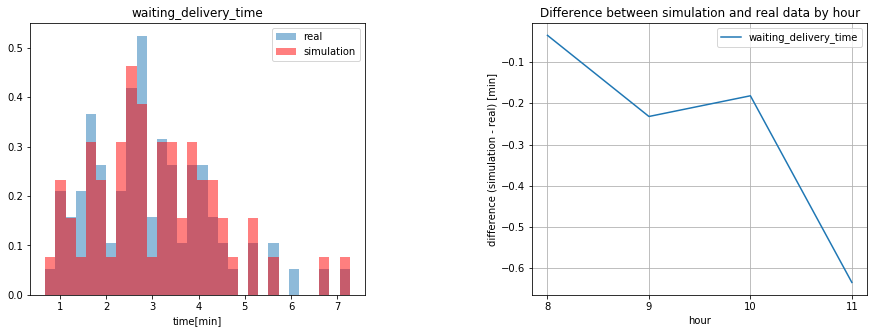

p-value = 0.97


$\Delta \mu = -0.12$ min [real - simulation]

In [178]:
col = 'waiting_delivery_time'

plot_time_comp_distr_and_hours(real_dt, sim_dt, col)

#### Edge cases review

In [179]:
fields = ['order_id', 'waiting_delivery_time']

#sim_dt.columns

sim_real_waiting_delivery_time = pd.merge(real_dt[fields], sim_dt[fields], how = "inner", on = "order_id")
sim_real_waiting_delivery_time['sim_real_waiting_delivery_time_gap'] = \
sim_real_waiting_delivery_time.waiting_delivery_time_x - sim_real_waiting_delivery_time.waiting_delivery_time_y

sim_real_waiting_delivery_time= sim_real_waiting_delivery_time.sort_values('sim_real_waiting_delivery_time_gap', ascending = False)


display(sim_real_waiting_delivery_time.head(10))
display(sim_real_waiting_delivery_time.tail(10))

real_dt.waiting_delivery_time.describe()

,order_id,waiting_delivery_time_x,waiting_delivery_time_y,sim_real_waiting_delivery_time_gap
0,81901831,4.716667,4.716667,0.0
63,81917536,3.550000,3.550000,0.0
45,81919879,3.400000,3.400000,0.0
46,81914126,0.683333,0.683333,0.0
48,81915968,2.750000,2.750000,0.0
49,81850452,2.583333,2.583333,0.0
50,81912601,1.200000,1.200000,0.0
52,81908951,2.416667,2.416667,0.0
53,81909503,2.750000,2.750000,0.0
54,81923888,2.783333,2.783333,0.0


,order_id,waiting_delivery_time_x,waiting_delivery_time_y,sim_real_waiting_delivery_time_gap
61,81927615,2.983333,NaN,NaN
64,81929213,2.716667,NaN,NaN
69,81928576,1.950000,NaN,NaN
75,81925328,1.566667,NaN,NaN
76,81923195,4.150000,NaN,NaN
77,81927461,1.100000,NaN,NaN
83,81925485,1.433333,NaN,NaN
84,81924441,3.233333,NaN,NaN
85,81922886,2.183333,NaN,NaN
86,81893148,2.550000,NaN,NaN


count    87.000000
mean      2.968199
std       1.323156
min       0.683333
25%       1.941667
50%       2.783333
75%       3.841667
max       7.266667
Name: waiting_delivery_time, dtype: float64

# Courier Delivery Time

## Daily aggregation

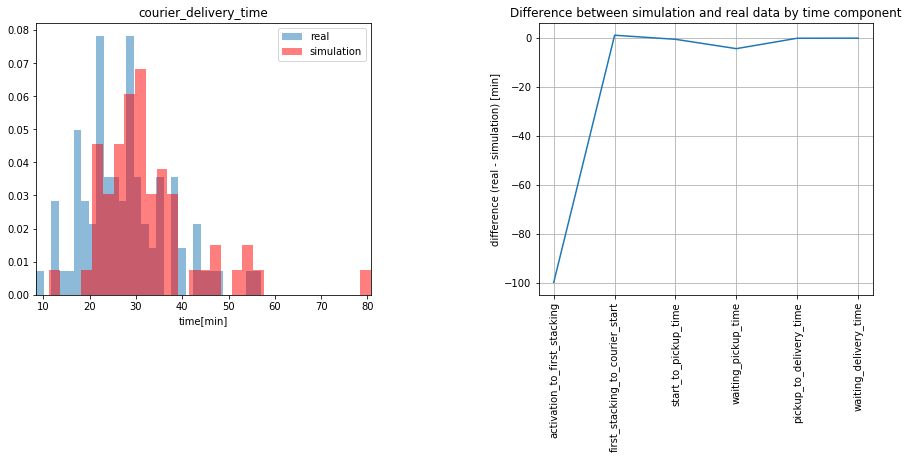

p-value = 0.01


$\Delta \mu = -6.93$ min [real - simulation]

,mean,std,outliers no,outliers %,q15,q85
sim,32.69,11.10,2,3.39,23.99,40.80
real,27.70,9.48,0,0.00,18.16,38.01


In [180]:
col = 'courier_delivery_time'

plot_distr_by_day_with_comps(col, time_components)

# Partner Metrics

## Activation to partner dispatch

### General overwiev

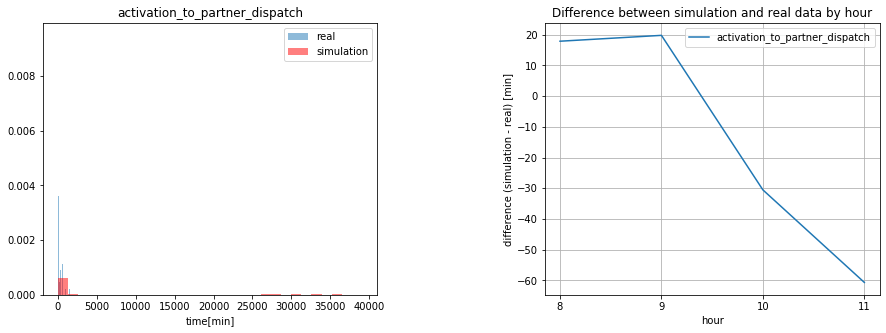

p-value = 0.01


$\Delta \mu = -6075.23$ min [real - simulation]

In [181]:
col = 'activation_to_partner_dispatch'

plot_time_comp_distr_and_hours(real_dt, sim_dt, col)

### Edge cases review

In [182]:
fields = ['order_id', 'activation_to_partner_dispatch']

#sim_dt.columns

sim_real_activation_to_partner_dispatch = pd.merge(real_dt[fields], sim_dt[fields], how = "inner", on = "order_id")
sim_real_activation_to_partner_dispatch['sim_real_activation_to_partner_dispatch_gap'] = \
sim_real_activation_to_partner_dispatch.activation_to_partner_dispatch_x - sim_real_activation_to_partner_dispatch.activation_to_partner_dispatch_y

sim_real_activation_to_partner_dispatch= sim_real_activation_to_partner_dispatch.sort_values('sim_real_activation_to_partner_dispatch_gap', ascending = False)


display(sim_real_activation_to_partner_dispatch.head(10))
display(sim_real_activation_to_partner_dispatch.tail(10))

real_dt.activation_to_partner_dispatch.describe()

,order_id,activation_to_partner_dispatch_x,activation_to_partner_dispatch_y,sim_real_activation_to_partner_dispatch_gap
32,81925728,1133,36.0,1097.0
82,81917724,1011,50.0,961.0
63,81917536,903,9.0,894.0
2,81926966,697,42.0,655.0
31,81927301,609,4.0,605.0
61,81927615,622,34.0,588.0
10,81910652,574,1.0,573.0
15,81918109,583,40.0,543.0
77,81927461,349,17.0,332.0
69,81928576,341,47.0,294.0


,order_id,activation_to_partner_dispatch_x,activation_to_partner_dispatch_y,sim_real_activation_to_partner_dispatch_gap
29,81850690,104,29457.0,-29353.0
49,81850452,65,30196.0,-30131.0
20,81847895,351,32499.0,-32148.0
78,81846119,607,33666.0,-33059.0
70,81845742,158,33391.0,-33233.0
79,81848113,584,33931.0,-33347.0
60,81845509,286,35541.0,-35255.0
71,81845420,275,36096.0,-35821.0
14,81846239,75,36299.0,-36224.0
22,81844642,15,39089.0,-39074.0


count      87.000000
mean      186.896552
std       278.544224
min         9.000000
25%        37.500000
50%        62.000000
75%       197.500000
max      1540.000000
Name: activation_to_partner_dispatch, dtype: float64

## Partner dispatch to enter pickup

### General overwiev

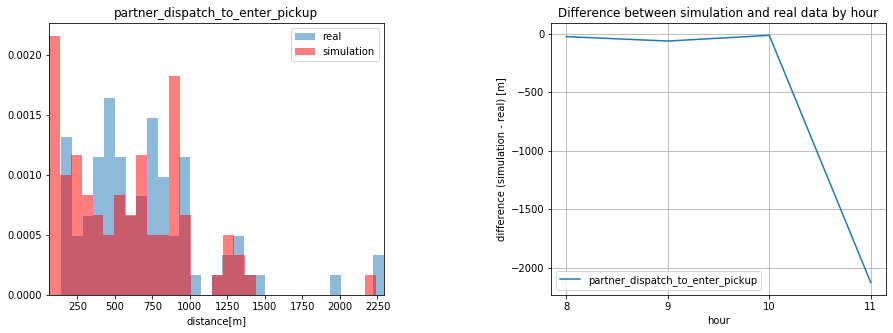

p-value = 0.04


$\Delta \mu = 130.44$ m [real - simulation]

In [183]:
col = 'partner_dispatch_to_enter_pickup'

plot_dist_comp_distr_and_hours(col)

### Edge cases review

In [184]:
fields = ['order_id', 'partner_dispatch_to_enter_pickup']

#sim_dt.columns

sim_real_partner_dispatch_to_enter_pickup = pd.merge(real_dt[fields], sim_dt[fields], how = "inner", on = "order_id")
sim_real_partner_dispatch_to_enter_pickup['sim_real_partner_dispatch_to_enter_pickup_gap'] = \
sim_real_partner_dispatch_to_enter_pickup.partner_dispatch_to_enter_pickup_x - sim_real_partner_dispatch_to_enter_pickup.partner_dispatch_to_enter_pickup_y

sim_real_partner_dispatch_to_enter_pickup= sim_real_partner_dispatch_to_enter_pickup.sort_values('sim_real_partner_dispatch_to_enter_pickup_gap', ascending = False)


display(sim_real_partner_dispatch_to_enter_pickup.head(10))
display(sim_real_partner_dispatch_to_enter_pickup.tail(10))

real_dt.partner_dispatch_to_enter_pickup.describe()

,order_id,partner_dispatch_to_enter_pickup_x,partner_dispatch_to_enter_pickup_y,sim_real_partner_dispatch_to_enter_pickup_gap
75,81925328,86399,96.0,86303.0
32,81925728,86399,180.0,86219.0
25,81904275,2292,762.0,1530.0
36,81921336,1972,701.0,1271.0
77,81927461,1410,238.0,1172.0
28,81915980,1356,210.0,1146.0
22,81844642,2276,1181.0,1095.0
12,81908950,1258,215.0,1043.0
86,81893148,996,61.0,935.0
39,81918248,1273,405.0,868.0


,order_id,partner_dispatch_to_enter_pickup_x,partner_dispatch_to_enter_pickup_y,sim_real_partner_dispatch_to_enter_pickup_gap
59,81844788,172,862.0,-690.0
43,81909295,544,1244.0,-700.0
53,81909503,626,1395.0,-769.0
70,81845742,156,927.0,-771.0
15,81918109,443,1253.0,-810.0
10,81910652,450,2238.0,-1788.0
17,81929197,309,NaN,NaN
26,81929299,384,NaN,NaN
64,81929213,1333,NaN,NaN
69,81928576,632,NaN,NaN


count       87.000000
mean      2675.218391
std      12924.098654
min        142.000000
25%        427.000000
50%        646.000000
75%        915.000000
max      86399.000000
Name: partner_dispatch_to_enter_pickup, dtype: float64

# The distribution by hour

The picture below shows the difference between the average delivery time in each hour for simulation and real data. 
We penalize by setting weights the hours where we don't have enough data to make any conclusions (In such cases the average from too few records is not giving a relevant information about the distribution).

The measure of importance is defined as below:
$f(h)= |n_h^{sim} * {avg}_h^{sim} - n_h^{real} * avg_h^{real}|$

By looking on the peak values we can investigate the hours where we can expect some significant differences between the distributions.

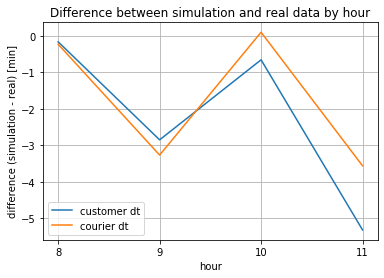

In [185]:
diff_dt_customer = get_overall_distr_by_hour("customer_delivery_time")
diff_dt_courier = get_overall_distr_by_hour("courier_delivery_time")

# plot the difference
fig= plt.figure()
ax = fig.gca()
plt.plot(diff_dt_customer["activation_time_hour"], diff_dt_customer["diff"], label="customer dt")
plt.plot(diff_dt_courier["activation_time_hour"], diff_dt_courier["diff"], label="courier dt")
ax.set_xticks(diff_dt_courier["activation_time_hour"])
plt.xlabel("hour")
plt.ylabel("difference (simulation - real) [min]")
plt.title("Difference between simulation and real data by hour")
plt.grid()
plt.legend()
plt.show()

## Customer Delivery Time

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pandas/core/indexing.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


 hour: **11**

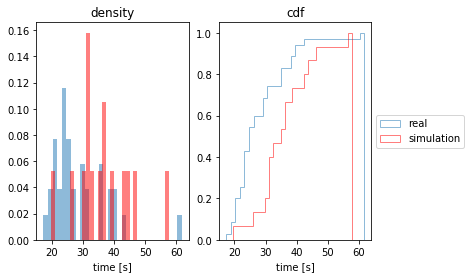

$\Delta \mu = -7.48$ min [real - simulation]

weighted $\Delta \mu = -5.32$ min [real - simulation]

,mean,std,outliers no,outliers %,q20,q80
sim,36.22,8.83,0,0.0,31.01,43.11
real,28.74,8.87,0,0.0,21.96,35.94


 hour: **9**

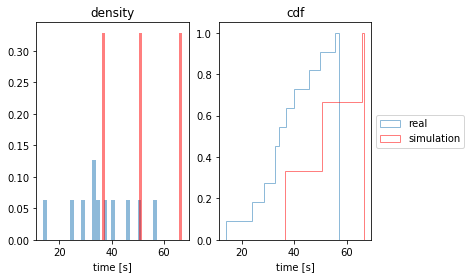

$\Delta \mu = -14.88$ min [real - simulation]

weighted $\Delta \mu = -2.85$ min [real - simulation]

,mean,std,outliers no,outliers %,q20,q80
sim,51.43,12.41,0,0.0,42.28,60.52
real,36.55,11.48,0,0.0,29.60,45.87


 hour: **10**

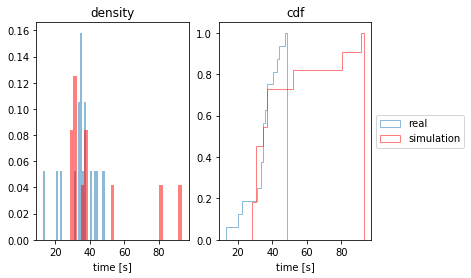

$\Delta \mu = -10.38$ min [real - simulation]

weighted $\Delta \mu = -0.65$ min [real - simulation]

,mean,std,outliers no,outliers %,q20,q80
sim,44.60,21.43,0,0.0,30.53,54.23
real,34.22,8.77,0,0.0,30.77,40.92


 hour: **8**

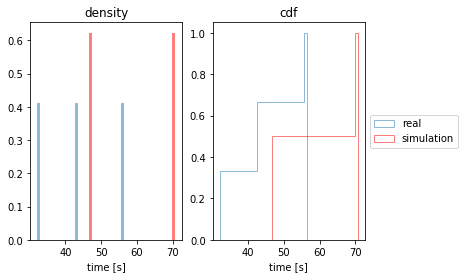

$\Delta \mu = -14.85$ min [real - simulation]

weighted $\Delta \mu = -0.16$ min [real - simulation]

,mean,std,outliers no,outliers %,q20,q80
sim,58.68,12.04,0,0.0,51.45,65.90
real,43.82,9.95,0,0.0,36.44,51.04


In [186]:
## by hour

col = 'customer_delivery_time'
def plot_distribution_for_each_hour(col):
    # percentiles
    q1 = 20
    q2 = 80
    th = 1.8
    diff_dt = get_overall_distr_by_hour(col)
    # sort dataframe by difference
    res = diff_dt[["activation_time_hour", "diff"]]
    res.loc[:,"abs_diff"] = abs(res.loc[:,"diff"])
    res = res.sort_values(by="abs_diff", ascending=False)[:5]

    # make the plot for each hour
    for hour in res["activation_time_hour"]:
        diff = round(res.loc[res["activation_time_hour"]==hour, "diff"].values[0],2)
    
        # filter by hour
        sim_dt_per_hour = sim_dt.loc[sim_dt["activation_time_hour"] == hour]
        real_dt_per_hour = real_dt.loc[real_dt["activation_time_hour"] == hour]

        # save plots distribution
        if (len(sim_dt_per_hour) > 0 and len(real_dt_per_hour) > 0):
            printmd(rf""" hour: **{hour}**""")
            

            # compute ks test

            # remove outliers
            real_dt_per_hour_no_outl, real_dt_per_hour_outl = detect_outliers(real_dt_per_hour[col], th, q1, q2)
            sim_dt_per_hour_no_outl, sim_dt_per_hour_outl = detect_outliers(sim_dt_per_hour[col], th, q1, q2)

            # make plots
            fig = plt.figure()

            # density
            plt.subplot(1,2,1)
            hist = plt.hist(real_dt_per_hour_no_outl, bins=30, label='real', alpha=0.5, density=True)
            hist1 = plt.hist(sim_dt_per_hour_no_outl, bins=30, color='r', label='simulation', alpha=0.5, density=True)
            #  plt.xlim((min(min(real_dt_per_hour[metric]), min(sim_dt[met])), max(max(real_dt[met]), max(sim_dt[met]))))
            plt.title("density")
            plt.xlabel("time [s]")

            # cdf
            plt.subplot(1, 2, 2)
            hist = plt.hist(real_dt_per_hour_no_outl, bins=30, label='real', alpha=0.5, density=True, cumulative=True, histtype='step')
            hist1 = plt.hist(sim_dt_per_hour_no_outl, bins=30, color='r', label='simulation', alpha=0.5, density=True, histtype='step',
                                                   cumulative=True)
            plt.title("cdf")
            plt.xlabel("time [s]")

            plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
         #   plt.suptitle("hour: %d, p-value = %.3f" %(hour, pvals_df[pvals_df["hour"]==hour]["pvalue"]))#
            plt.show()

            # print statistics

            print_avg_diff(real_dt_per_hour_no_outl, sim_dt_per_hour_no_outl)
            printmd(rf"""weighted $\Delta \mu = {diff}$ min [real - simulation]""")
            row_sim = get_statistics(sim_dt_per_hour_no_outl, sim_dt_per_hour_outl, "sim", q1,q2)
            real_sim = get_statistics(real_dt_per_hour_no_outl, real_dt_per_hour_outl, "real", q1,q2)
            display(row_sim.append(real_sim))
            
plot_distribution_for_each_hour(col)